In [12]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import r2_score
%matplotlib inline 

# 1. Preparing Data

### Loading HH Data

In [13]:
#hh_data = pd.read_csv("../Data/Intermediate_files/hh_village_coord_fcs.csv")

In [14]:
hh_data = pd.read_csv("../Data/Intermediate_files/hh_data_2011_cluster_minHH.csv")

### Loading CNN features

In [15]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features.csv")

In [16]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms.csv")

In [17]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGG16_block4_pool.csv")

In [18]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean.csv")

In [19]:
CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster.csv")

### Merging

In [20]:
data=hh_data.merge(CNN_features,on=["i","j"])

In [21]:
data = data.sample(frac=1).reset_index(drop=True) #Shuffling the data

In [22]:
start_features=len(hh_data.columns)+2

In [23]:
data_features=data.iloc[:,start_features:]

### Defining predictors and predicting variables

In [24]:
y = data["cons"].values #Average normalized consumption per cluster
y = y[y > 0]
y = np.log(y) #Log-normal distribution

In [55]:
y2 = data["poor_majority"] #Dummy variable for majority of poor in the cluster

In [26]:
X=data_features.values

In [27]:
X.shape

(309, 4096)

In [28]:
y.shape

(309,)

(array([  3.,  14.,  47.,  85.,  70.,  35.,  28.,  20.,   5.,   2.]),
 array([-0.40340905, -0.02670821,  0.34999262,  0.72669345,  1.10339428,
         1.48009511,  1.85679595,  2.23349678,  2.61019761,  2.98689844,
         3.36359927]),
 <a list of 10 Patch objects>)

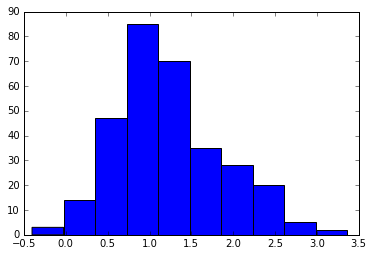

In [31]:
plt.hist(y)

In [32]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.284067,0.038011,0.016822,0.143997,0.390587,0.045573,0.476842,0.029291,0.101495,0.013032,...,0.015087,0.557196,0.000000,1.064649,0.222510,0.470572,0.067106,0.103971,0.088740,0.030557
1,0.322476,0.025439,0.002845,0.175601,0.401856,0.035674,0.350522,0.001553,0.066945,0.007635,...,0.016341,0.530396,0.000000,1.045707,0.150009,0.475484,0.040809,0.118733,0.129445,0.011645
2,0.267277,0.007738,0.004844,0.106270,0.391698,0.011633,0.503222,0.002290,0.018247,0.000926,...,0.004716,0.624740,0.000000,1.351610,0.163763,0.625130,0.029655,0.093986,0.065311,0.002003
3,0.661158,0.118361,0.342491,0.498499,0.507871,0.023105,0.583844,0.087549,0.901327,0.005383,...,0.089079,0.882059,0.000969,0.981167,0.048004,0.177469,0.145399,0.318241,0.682856,0.026480
4,0.291924,0.068823,0.017631,0.248543,0.326709,0.050860,0.399913,0.020031,0.143854,0.012067,...,0.041486,0.632786,0.000037,0.879723,0.170953,0.401817,0.048103,0.081173,0.164577,0.051656


# 2. Predicting Continuous Indicator

## From PCA Components

In [33]:
model=Ridge()

In [34]:
alphas = np.array([0.01,0.1,1,5,10,20,30,40,50])

In [35]:
inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)

In [36]:
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=inner_cv)

In [37]:
pca = PCA(n_components=10)

In [38]:
pca.fit(data_features.transpose())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
eigenvectors=pca.components_

In [40]:
X2 = pd.DataFrame(np.transpose(eigenvectors))
X2.shape

(309, 10)

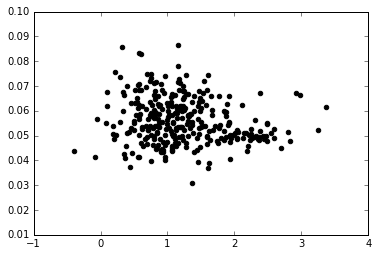

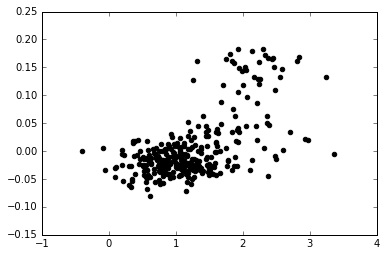

In [41]:
for i in range(2):
    plt.figure()
    plt.scatter(y, eigenvectors[i],  color='black')

In [42]:
r2 = cross_val_score(clf, X2, y, cv=outer_cv,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

R2: 0.40 (+/- 0.15)


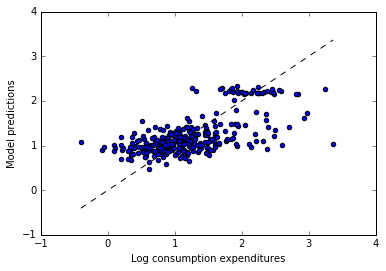

In [43]:
y_hat = cross_val_predict(clf, X2, y, cv=10)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

## From all (4096) features

In [44]:
model=Ridge()

In [45]:
alphas = np.array([1,5,10,20,30,40,50])

In [46]:
inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)

In [47]:
#Inner Loop 
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=inner_cv)

In [48]:
# Outer Loop
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

R2: 0.44 (+/- 0.15)


In [49]:
r2

array([ 0.52927336,  0.33544039,  0.3663976 ,  0.457522  ,  0.50415378])

In [50]:
neg_mean_squared_error = cross_val_score(clf, X, y, cv=outer_cv,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (-neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: 0.24 (+/- 0.09)


In [51]:
-neg_mean_squared_error

array([ 0.30552487,  0.27347175,  0.21047703,  0.17502719,  0.23714026])

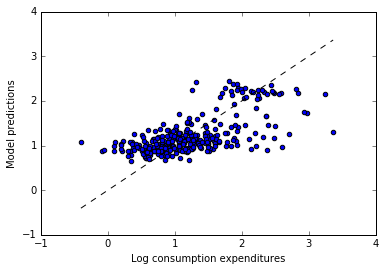

In [52]:
y_hat = cross_val_predict(clf, X, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

In [53]:
r2_score(y,y_hat)

0.42119267860429532

# 3. Predicting Dummy Indicator from all features

In [56]:
model = linear_model.LogisticRegression(penalty="l2")
model.fit(X, y2) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
cv = KFold(n_splits=10, shuffle=True)

In [58]:
accuracy = cross_val_score(model, X, y2, cv=cv)
f1 = cross_val_score(model, X, y2, cv=cv,scoring='f1')
precision = cross_val_score(model, X, y2, cv=cv,scoring='precision')
recall= cross_val_score(model, X, y2, cv=cv,scoring='recall')
auc= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')
confusion= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')

In [59]:
scores = cross_val_score(model, X, y2, cv=10,scoring='precision')
accuracy_print=("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
f1_print=("F1: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))
precision_print=("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall_print=("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
auc_print=("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))
print(os.linesep.join([accuracy_print,f1_print,precision_print,recall_print,auc_print]))

Accuracy: 0.77 (+/- 0.11)
F1: 0.46 (+/- 0.37)
Precision: 0.64 (+/- 0.45)
Recall: 0.35 (+/- 0.32)
AUC: 0.80 (+/- 0.18)


In [60]:
y2.describe()

count    309.000000
mean       0.258900
std        0.438741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: poor_majority, dtype: float64